In [2]:
# Import necessary libraries
import os 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from IPython.display import display
from os import listdir
from os.path import isfile, join
from PIL import Image

# For the Model and Visualization
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix

# Prevention of warning popups
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Path locating of the directory
dir_name_train_COVID = 'Dataset/train/Covid'
dir_name_train_PNEUMONIA = 'Dataset/train/Viral Pneumonia'
dir_name_train_NORMAL = 'Dataset/train/Normal'

In [4]:
# Path locating of the directory
training_path = "Dataset/train"
testing_path = "Dataset/test"
validation_path = "Dataset/validation/"

In [5]:
# Image DataGenerator coming from the Directory
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=training_path, target_size=(224,224), classes=['Covid','Viral Pneumonia', 'Normal'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=testing_path, target_size=(224,224), classes=['Covid','Viral Pneumonia', 'Normal'], batch_size=10, shuffle=False)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=validation_path, target_size=(224,224), classes=['Covid','Viral Pneumonia', 'Normal'], batch_size=10)

Found 249 images belonging to 3 classes.
Found 65 images belonging to 3 classes.
Found 0 images belonging to 3 classes.


In [6]:
# Plotting of the images 
def plot_images(item_dir, n=6):
    all_item_dir = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dir][:n]
    
    plt.figure(figsize=(35,10))
    for idx, img_path in enumerate(item_files):
        plt.subplot(2, n, idx+1)
        img = plt.imread(img_path)
        plt.imshow(img,cmap='gray')
        plt.axis('off')

    # Visualization of the plot        
    plt.tight_layout()

In [7]:
# Plotting of the images
def Images_details_Print_data(data,path):
    print("===== Images in:", path)
    for k, v in data.items():
        print("%s:\t%s" %(k, v))
# Plotting of the images by path
def Images_details(path):
    files = [f for f in glob.glob(path + "**/*.*", recursive = True)]
    data = {}
    data['images_count'] = len(files)
    data['min_width'] = 10**100 # Dedicated image size
    data['max_width'] = 0
    data['min_height'] = 10**100 # Dedicated image size
    data['max_height'] = 0
    
    for f in files:
        im = Image.open(f)
        width, height = im.size
        data['min_width'] = min(width, data['min_width'])
        data['max_width'] = max(width, data['max_height'])
        data['min_height'] = min(height, data['min_height'])
        data['max_height'] = max(height, data['max_height'])
        
    Images_details_Print_data(data, path)


Trained data for COVID19 type disease:

===== Images in: Dataset/train/Covid
images_count:	112
min_width:	439
max_width:	4095
min_height:	391
max_height:	4095



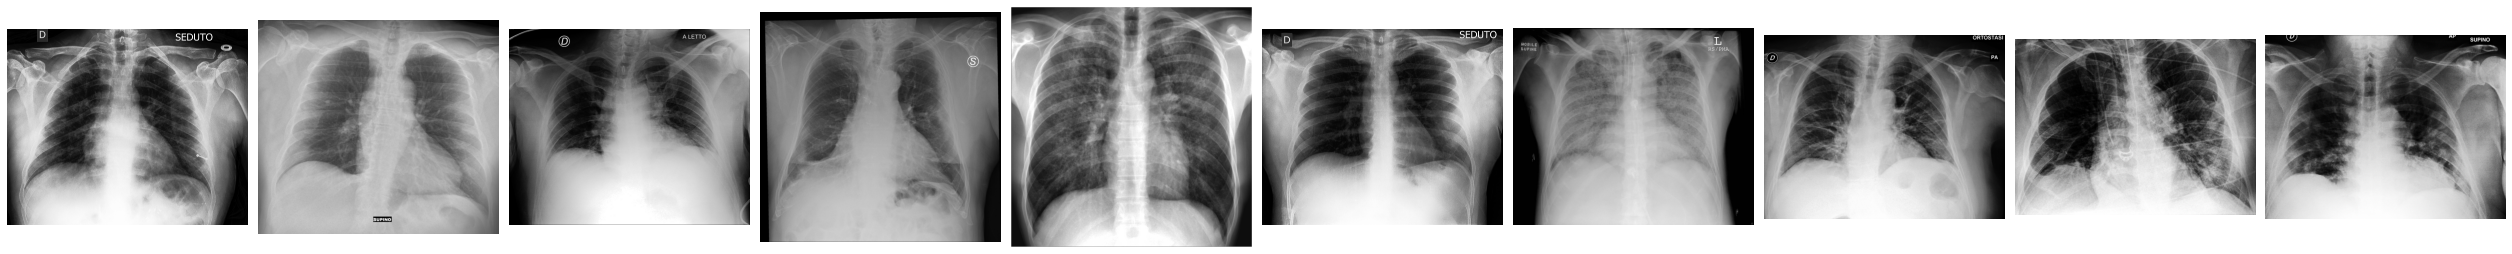

In [8]:
# Visualize the trained dataset for COVID
print("")
print("Trained data for COVID19 type disease:")
print("")
Images_details(dir_name_train_COVID)
print("")
plot_images(dir_name_train_COVID, 10)


Trained data for PNEUMONIA:

===== Images in: Dataset/train/Viral Pneumonia
images_count:	70
min_width:	1056
max_width:	1456
min_height:	744
max_height:	1456



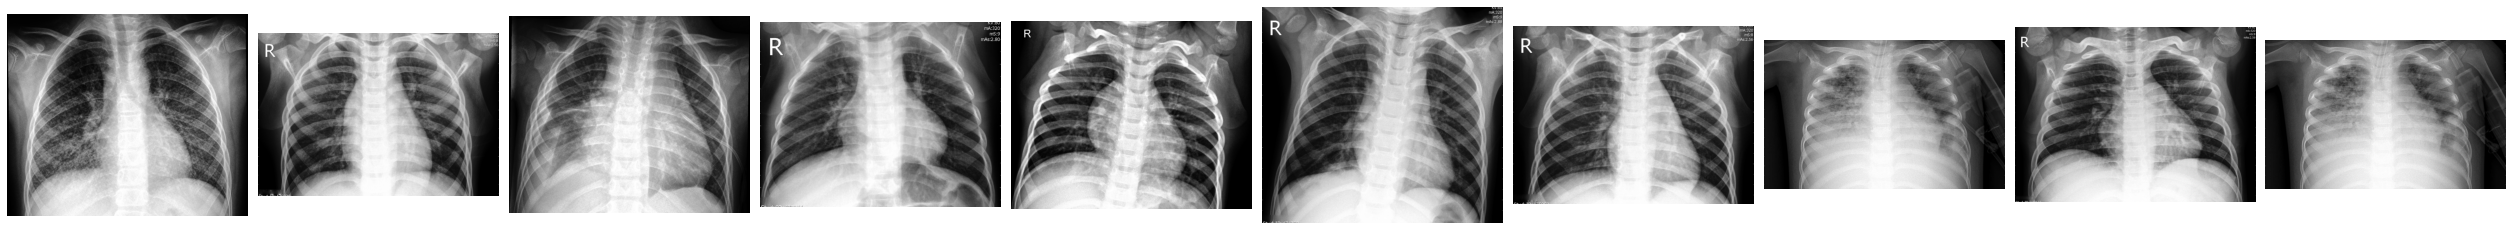

In [9]:
# Visualize the trained dataset for Pneumonia
print("")
print("Trained data for PNEUMONIA:")
print("")
Images_details(dir_name_train_PNEUMONIA)
print("")
plot_images(dir_name_train_PNEUMONIA, 10)


Trained data for NORMAL:

===== Images in: Dataset/train/Normal
images_count:	67
min_width:	1534
max_width:	2713
min_height:	1063
max_height:	2713



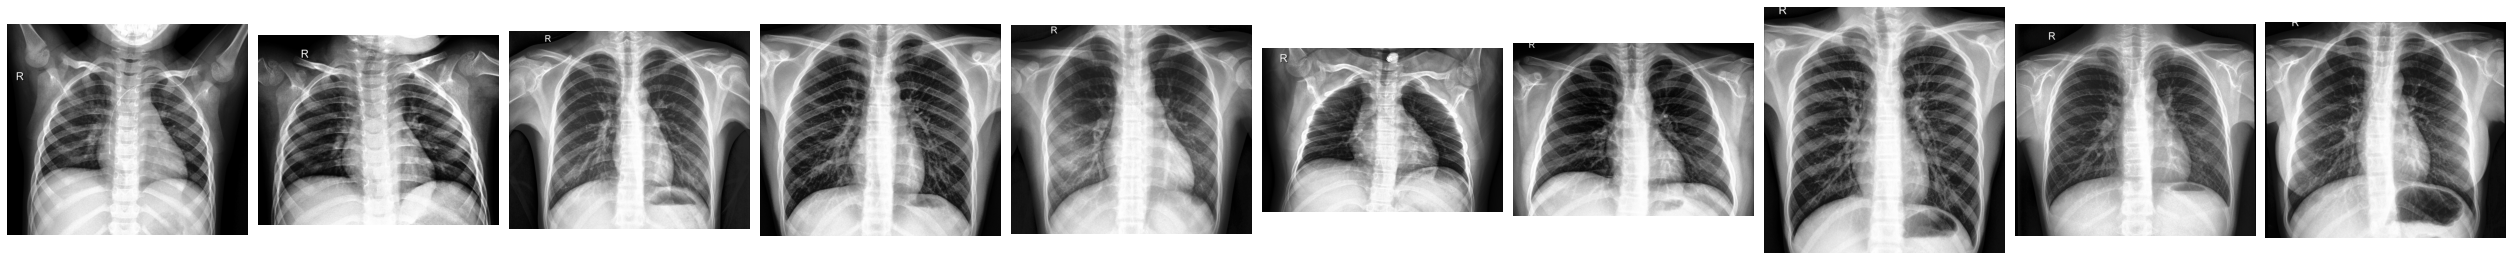

In [10]:
# Visualize the trained dataset for Normal
print("")
print("Trained data for NORMAL:")
print("")
Images_details(dir_name_train_NORMAL)
print("")
plot_images(dir_name_train_NORMAL, 10)

In [11]:
# Defining the model
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=3, activation='softmax')
    ])

# Information summary for the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 3)                 6

In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Batch size that is been used in the pre-processing is 10
batch_size = 10 

# Fitting the Model
history = model.fit(
    x = train_batches, 
    steps_per_epoch=train_batches.samples // batch_size, 
    epochs=10, 
    validation_data=test_batches, 
    validation_steps=test_batches.samples // batch_size,
    verbose=2)

Epoch 1/10
24/24 - 14s - loss: 23.2521 - accuracy: 0.6485 - val_loss: 10.6553 - val_accuracy: 0.7333 - 14s/epoch - 575ms/step
Epoch 2/10
24/24 - 11s - loss: 2.6665 - accuracy: 0.9163 - val_loss: 8.1233 - val_accuracy: 0.7833 - 11s/epoch - 476ms/step
Epoch 3/10
24/24 - 12s - loss: 0.9860 - accuracy: 0.9665 - val_loss: 4.2316 - val_accuracy: 0.8167 - 12s/epoch - 483ms/step
Epoch 4/10
24/24 - 11s - loss: 0.1803 - accuracy: 0.9874 - val_loss: 5.0071 - val_accuracy: 0.8000 - 11s/epoch - 473ms/step
Epoch 5/10
24/24 - 13s - loss: 0.1837 - accuracy: 0.9874 - val_loss: 4.3301 - val_accuracy: 0.8333 - 13s/epoch - 557ms/step
Epoch 6/10
24/24 - 12s - loss: 0.1720 - accuracy: 0.9833 - val_loss: 5.3572 - val_accuracy: 0.7833 - 12s/epoch - 514ms/step
Epoch 7/10
24/24 - 12s - loss: 0.0212 - accuracy: 0.9916 - val_loss: 3.1598 - val_accuracy: 0.8500 - 12s/epoch - 506ms/step
Epoch 8/10
24/24 - 12s - loss: 0.0395 - accuracy: 0.9958 - val_loss: 2.7802 - val_accuracy: 0.8500 - 12s/epoch - 508ms/step
Epoch 

In [14]:
# Graphing our training and validation metrics
def graph():
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(['Train, Test'], loc = 'upper left')
    plt.legend(loc='upper right')
    plt.show()
    
    # Training & Validation of the plot for the loss values
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim([0.5, 1])
    plt.legend(['Train, Test'], loc = 'upper right')
    plt.show()

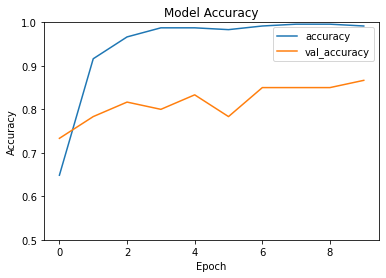

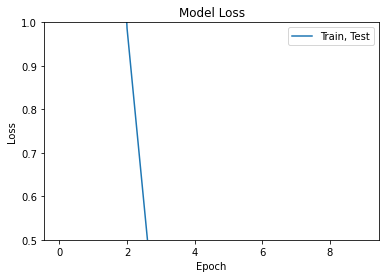

In [15]:
# Visualize the Graph Model Accuracy and Model Loss
graph()

In [16]:
# Building Predictions
predictions = model.predict(x = test_batches, verbose=0)

In [17]:
# Defining the Confusion Matrix

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')       

Text(0.5, 6.800000000000011, 'Predicted label')

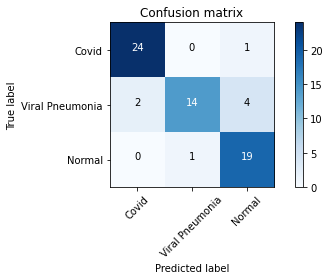

In [18]:
# Displaying the Confusion Matrix of Predictions for the True Labels
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
plot_confusion_matrix(cm, classes = ['Covid', 'Viral Pneumonia', 'Normal'])

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [21]:
# Give the classes C, V, N

classes = ['C','V', 'N']

lbl = []
out = []

# Accessing the jpeg in directory by creating a loop
for i in os.listdir(validation_path):
    val_img = tf.keras.utils.load_img(validation_path+i,target_size=(224,224))
    val_img = tf.keras.utils.img_to_array(val_img)
    val_img = np.expand_dims(val_img,axis=0)
    predict_x=model.predict(val_img)
    output = classes[np.argmax(predict_x)]
    lbl.append(i)
    out.append(output)
    print("Picture #", i,"\n Diagnosis: ", output)

1/1 [==============================] - 0s 127ms/step
Picture # pic1.jpeg 
 Diagnosis:  C
1/1 [==============================] - 0s 66ms/step
Picture # pic10.jpeg 
 Diagnosis:  C
1/1 [==============================] - 0s 38ms/step
Picture # pic2.jpeg 
 Diagnosis:  C
1/1 [==============================] - 0s 42ms/step
Picture # pic3.jpeg 
 Diagnosis:  C
1/1 [==============================] - 0s 39ms/step
Picture # pic4.jpeg 
 Diagnosis:  V
1/1 [==============================] - 0s 38ms/step
Picture # pic5.jpeg 
 Diagnosis:  V
1/1 [==============================] - 0s 44ms/step
Picture # pic6.jpeg 
 Diagnosis:  C
1/1 [==============================] - 0s 25ms/step
Picture # pic7.jpg 
 Diagnosis:  C
1/1 [==============================] - 0s 28ms/step
Picture # pic8.jpeg 
 Diagnosis:  V
1/1 [==============================] - 0s 29ms/step
Picture # pic9.jpeg 
 Diagnosis:  C


In [22]:
# Combining the list and creating a dataframe
lbl = pd.DataFrame(lbl, columns = ["Picture #"])
out = pd.DataFrame(out, columns = ['Diagnosis'])

final_output = pd.concat([lbl, out], axis = 1)
final = final_output.set_index("Picture #")

In [23]:
# Extraction of the dataframe to create the CSV file
final.to_csv('tuna_covid_output.csv')

In [26]:
#Printing train and test accuracy
train=history.history['accuracy'][-1]
test=history.history['val_accuracy'][-1]
print("The training_accuracy:", train*100, "%") 
print("Testing_accuracy:", test*100, "%")

The training_accuracy: 99.1631805896759 %
Testing_accuracy: 86.66666746139526 %
